# Import & Load Data

In [88]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import scipy.stats as stats

In [62]:
trans_df = pd.read_csv('D:/Siraj/CyberSecurity_Week/ieee-fraud-detection/train_transaction.csv', low_memory=False)
id_df = pd.read_csv('D:/Siraj/CyberSecurity_Week/ieee-fraud-detection/train_identity.csv', low_memory=False)


In [63]:
train_full_df = pd.merge(trans_df, id_df, on='TransactionID', how='left')


Reducing Memory

In [64]:
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [65]:
train_full_df = reduce_mem_usage(train_full_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)


Visualizing Data 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

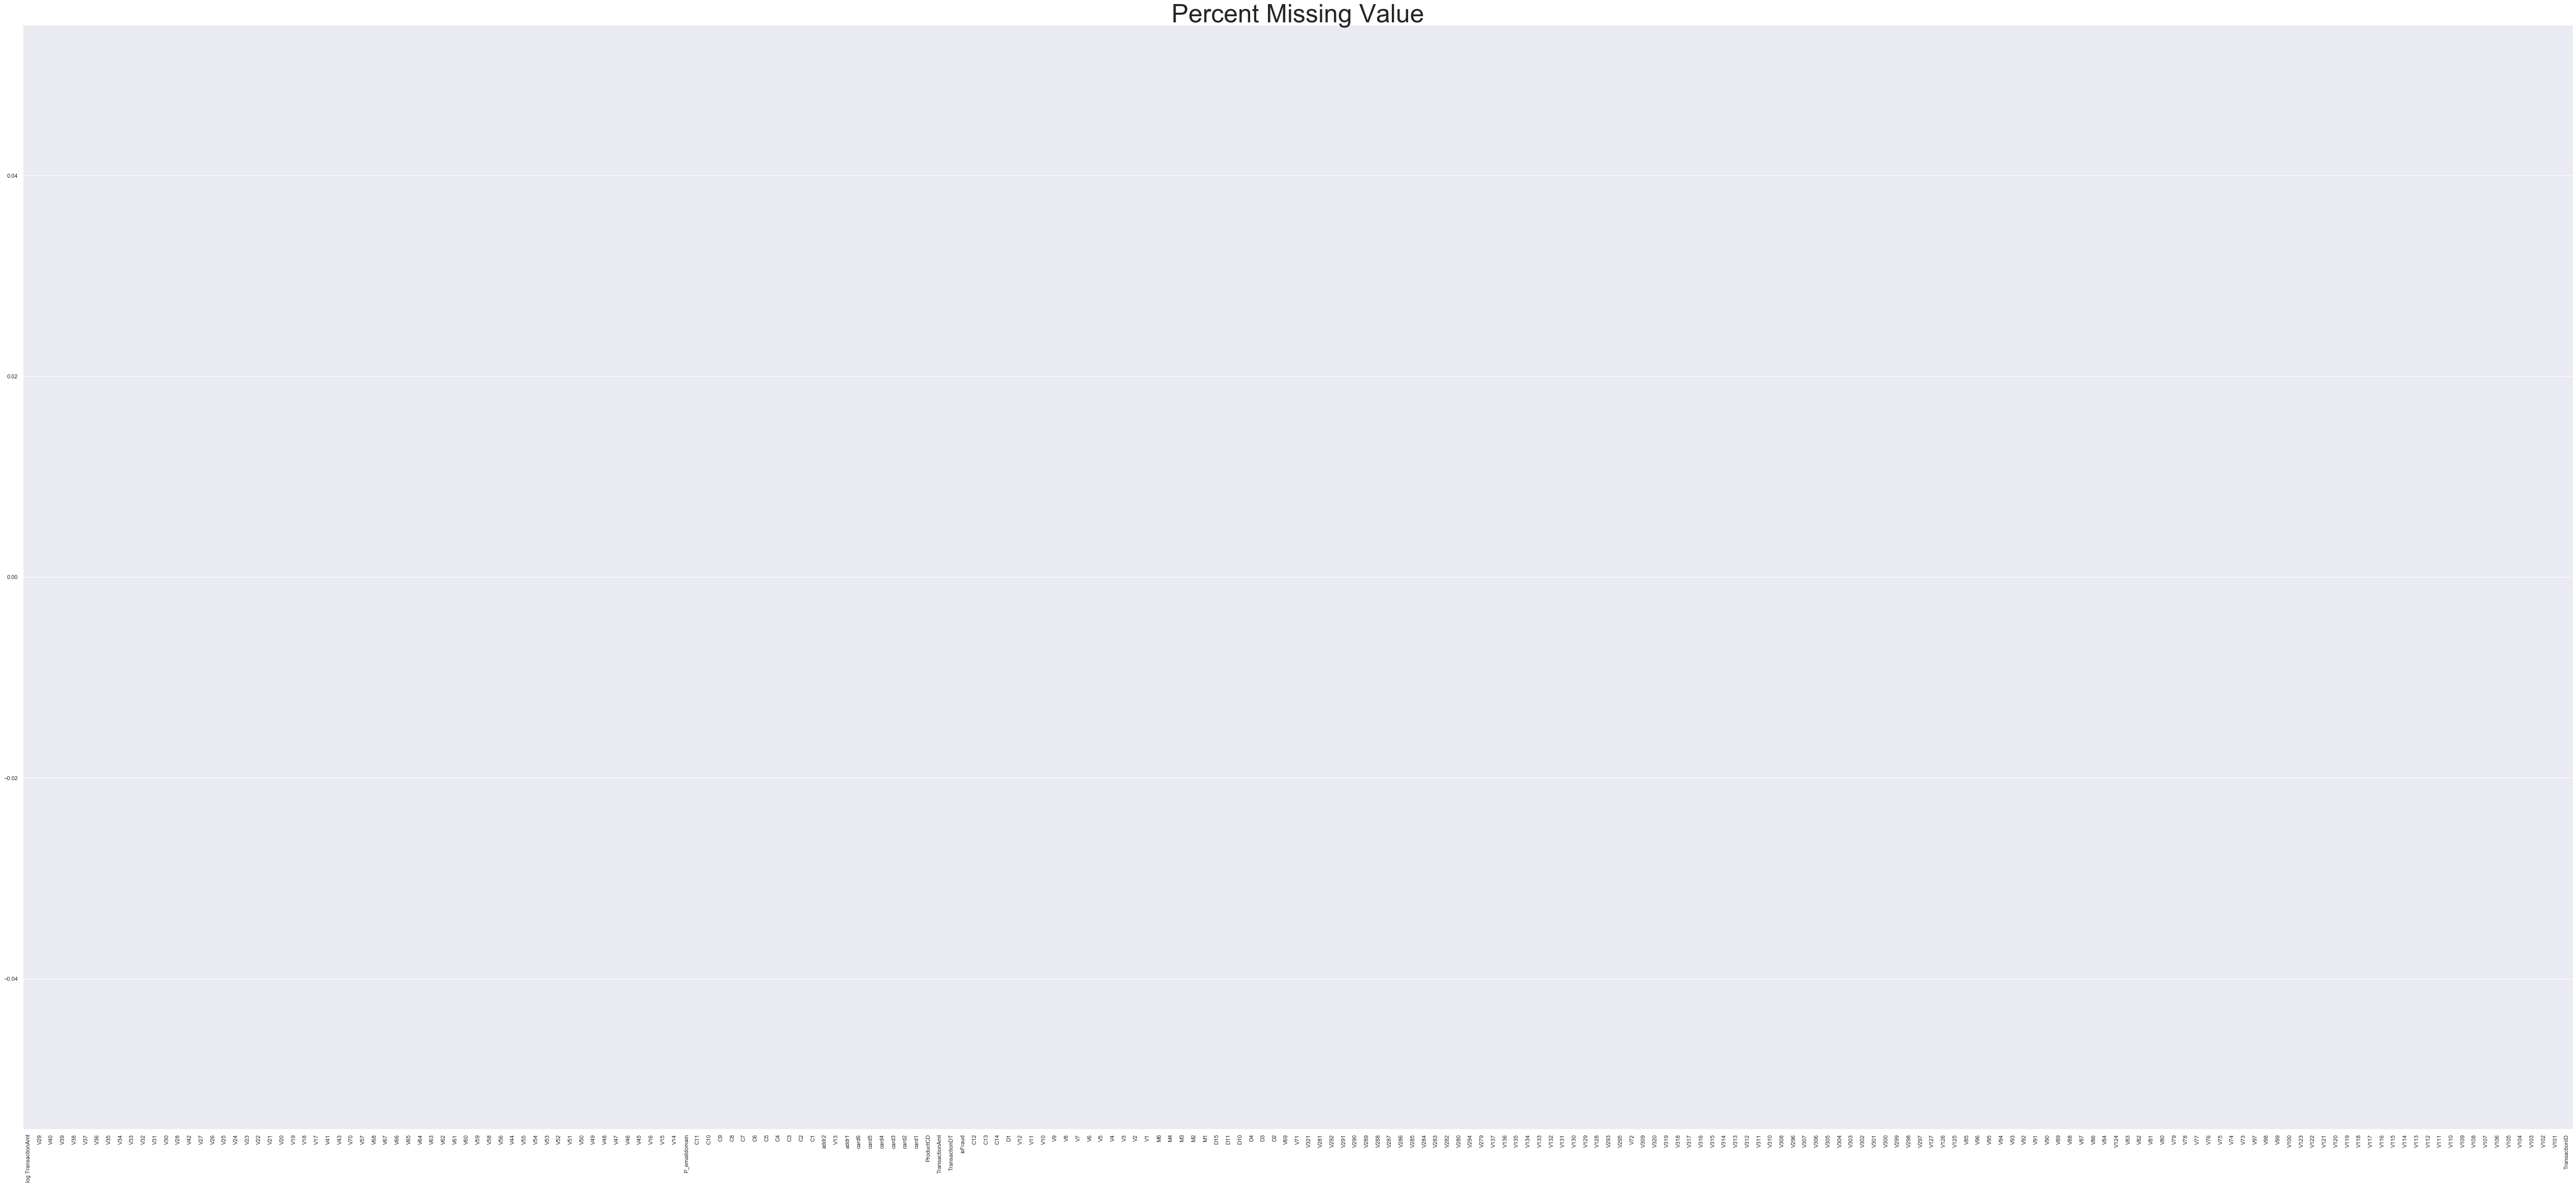

In [90]:
#Plotting Columns According to NA Values 
plt.figure(figsize=(90,40))
sns.barplot(y=train_full_df.isnull().sum().sort_values(ascending=False)/len(train_full_df),
            x=train_full_df.isnull().sum().sort_values(ascending=False).index,
            palette="Reds_d")
plt.title("Percent Missing Value",size=50)
plt.xticks(rotation=90)

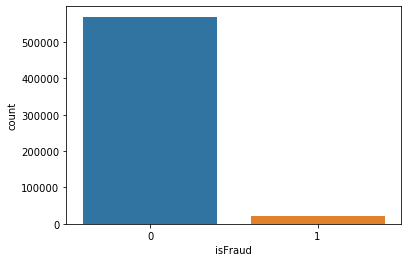

In [85]:
sns.countplot(x='isFraud', data = train_full_df)

D:\Program_Files\Conda\envs\fastai-v3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


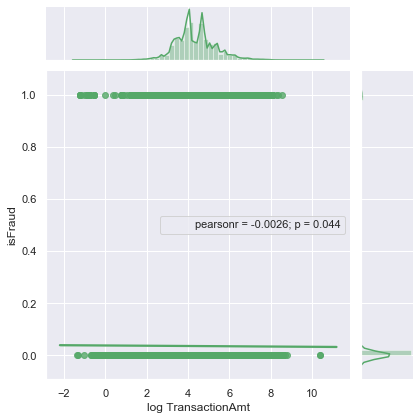

In [89]:
#taking log because of large range of data values.
train_full_df['log TransactionAmt'] = np.log(train_full_df['TransactionAmt'])

sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot(data = train_full_df, x='log TransactionAmt', y='isFraud', color='g', kind='reg')
j.annotate(stats.pearsonr)
plt.show()

#Visualising relation between Transaction Amount and Fraudulent Transactions

# Data PreProcessing

Handling NA Values

In [69]:
### Remove columns with null percent more than 50.
### Fill NaNs and infs  


null_percent = train_full_df.isnull().sum()/train_full_df.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 50].index)

def trimandfillnanandinfs(df, cols_to_drop):
    df = df.drop(cols_to_drop, axis=1)
    df = df.fillna(-999)
    df = df.replace([np.inf, -np.inf], -999)
    return df

train_full_df = trimandfillnanandinfs(train_full_df, cols_to_drop)
print(cols_to_drop)

['dist1' 'dist2' 'R_emaildomain' 'D5' 'D6' 'D7' 'D8' 'D9' 'D12' 'D13'
 'D14' 'M5' 'M7' 'M8' 'M9' 'V138' 'V139' 'V140' 'V141' 'V142' 'V143'
 'V144' 'V145' 'V146' 'V147' 'V148' 'V149' 'V150' 'V151' 'V152' 'V153'
 'V154' 'V155' 'V156' 'V157' 'V158' 'V159' 'V160' 'V161' 'V162' 'V163'
 'V164' 'V165' 'V166' 'V167' 'V168' 'V169' 'V170' 'V171' 'V172' 'V173'
 'V174' 'V175' 'V176' 'V177' 'V178' 'V179' 'V180' 'V181' 'V182' 'V183'
 'V184' 'V185' 'V186' 'V187' 'V188' 'V189' 'V190' 'V191' 'V192' 'V193'
 'V194' 'V195' 'V196' 'V197' 'V198' 'V199' 'V200' 'V201' 'V202' 'V203'
 'V204' 'V205' 'V206' 'V207' 'V208' 'V209' 'V210' 'V211' 'V212' 'V213'
 'V214' 'V215' 'V216' 'V217' 'V218' 'V219' 'V220' 'V221' 'V222' 'V223'
 'V224' 'V225' 'V226' 'V227' 'V228' 'V229' 'V230' 'V231' 'V232' 'V233'
 'V234' 'V235' 'V236' 'V237' 'V238' 'V239' 'V240' 'V241' 'V242' 'V243'
 'V244' 'V245' 'V246' 'V247' 'V248' 'V249' 'V250' 'V251' 'V252' 'V253'
 'V254' 'V255' 'V256' 'V257' 'V258' 'V259' 'V260' 'V261' 'V262' 'V263'
 'V264' '

In [70]:
x_full_df = train_full_df.drop(["isFraud"],axis=1)
y_full_df = train_full_df["isFraud"]

Split into Train & Test Data

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_full_df, y_full_df, test_size=0.50)

Dealing with categorical variables

One Hot Encoding

In [72]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

D:\Program_Files\Conda\envs\fastai-v3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Program_Files\Conda\envs\fastai-v3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
X_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
98846,3085846,1989293,107.9375,4,9992,455.0,150.0,3,166.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38614,3025614,945905,50.0000,4,18132,567.0,150.0,3,117.0,3,...,0.0,59.0,59.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0
1215,2988215,127901,100.0000,4,14540,276.0,150.0,4,226.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,1890.0,750.0
298003,3285003,7351798,32.6250,0,15885,545.0,185.0,4,138.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364990,3351990,9062722,59.0000,4,12219,-999.0,150.0,4,166.0,3,...,0.0,113.0,171.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
263551,3250551,6368466,117.0,4,9500,321.0,150.0,4,226.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560631,3547631,14851287,100.0,2,14037,111.0,150.0,4,226.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0
398533,3385533,10037217,211.0,4,9500,321.0,150.0,4,226.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459053,3446053,11757483,30.0,1,9350,111.0,150.0,4,162.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374485,3361485,9327332,250.0,4,9537,583.0,150.0,4,226.0,2,...,2132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.0,0.0


# Logistic Regression Model


In [75]:
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [76]:
lr = LogisticRegression(solver='lbfgs')  
lr.fit(X_train, y_train)

D:\Program_Files\Conda\envs\fastai-v3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:

lr.score(X_test, y_test)

0.9647610661428523

In [78]:
y_pred=lr.predict(X_test)

In [79]:
accuracy_score(y_test, y_pred)


0.9647610661428523

In [80]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.18772036079538015

In [81]:
from imblearn.metrics import classification_report_imbalanced
# Calculate confusion matrix 
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Get the classification report 
print(classification_report_imbalanced(y_true=y_test, y_pred=y_pred,\
                                       target_names=['Not Fraud', 'Fraud']))

                   pre       rec       spe        f1       geo       iba       sup

  Not Fraud       0.96      1.00      0.00      0.98      0.00      0.00    284867
      Fraud       0.00      0.00      1.00      0.00      0.00      0.00     10403

avg / total       0.93      0.96      0.04      0.95      0.00      0.00    295270



In [82]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  """
  Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

  Parameters
  ---------
  confusion_matrix: numpy.ndarray
      The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
  class_names: list
      An ordered list of class names, in the order they index the given confusion matrix.
  figsize: tuple
      A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
      the second determining the vertical size. Defaults to (10,7).
  fontsize: int
      Font size for axes labels. Defaults to 14.
      
  Returns
  -------
  matplotlib.figure.Figure
      The resulting confusion matrix figure
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
  fig = plt.figure(figsize=figsize)
  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,\
                               ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,\
                               ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return fig

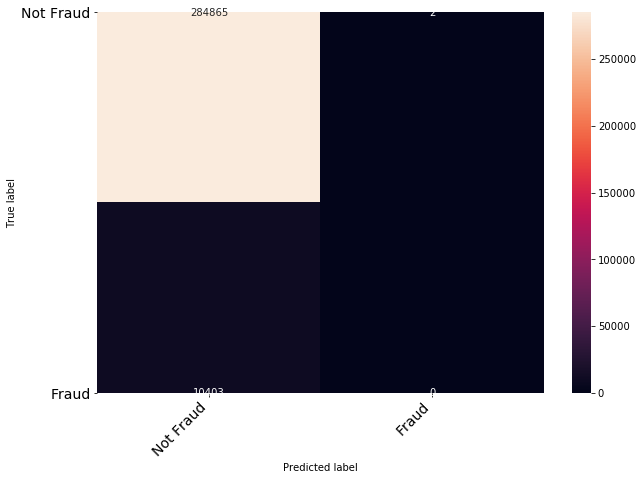

In [83]:
print_confusion_matrix(confusion_mat, ['Not Fraud', 'Fraud']);